# Chebyshev補間の微分

Chebyshev多項式の有限和で表される関数を本稿では**Chebyshev補間**という。Chebyshev補間

$$p(x)=\sum^{M-1}_{n=0}a_nT_n(x)$$

に対して、その微分

$$p'(x)=\sum_{n=0}^{M-2}b_nT_n(x),\quad {}^\prime = \frac d{dx}$$

を求める。係数 $a_n$ と $b_n$ の関係を調べる。

$$p(x)=\int p(x)'dx=\int \sum_{n=0}^{M-2}b_nT_n(x)dx $$

であるから、$T_n(x)=\cos n\theta$ $(x=\cos\theta)$ という事実から

$$
\begin{align*}
\int T_n(x)dx&=\int -\cos n\theta\sin\theta d\theta \\
&=-\frac{1}{2}\int(\sin (n+1)\theta-\sin (n-1)\theta)d\theta \\
&=\frac{1}{2}\left[\frac{\cos (n+1)\theta}{n+1}-\frac{\cos (n-1)\theta}{n-1}\right]\\
&=\frac{1}{2}\left[\frac{T_{n+1}(x)}{n+1}-\frac{T_{n-1}(x)}{n-1}\right].
\end{align*}
$$

よって積分による定数倍を除けば、

$$
\begin{align*}
\int T_n(x)dx=\begin{cases}
\frac{1}{2}\left[\frac{T_{n+1}(x)}{n+1}-\frac{T_{n-1}(x)}{n-1}\right] & (n\ge 2)\\
\frac14 T_2(x) & (n=1)\\
T_1(x) & (n=0).
\end{cases}
\end{align*}
$$

従って、
$$
\begin{align*}
p(x)=\int p(x)'dx&=C +b_0T_1(x)+\frac{1}{4}b_1T_2(x)+\sum^{M-2}_{n=2}\frac{b_n}{2}\left[\frac{T_{n+1}(x)}{n+1}-\frac{T_{n-1}(x)}{n-1}\right] \\
&=\sum^{M-1}_{n=0}a_nT_n(x).
\end{align*}
$$


つまり $a_n$ と $b_n$ の関係は以下の漸化式で表すことができる。

$$
\begin{align*}
b_{n-1}&=b_{n+1}+2na_n,\quad(n=M-1,M-2,\dots,2),\quad b_{M+1}=b_{M}=0,\\
2b_0&=b_2+2a_1.
\end{align*}
$$

**注**　最後の $b_0$ の項は $b_0'=2b_0$ とおいて漸化式を $n=M-1,M-2,\dots,1$ として計算し、最後に $b_0=b_0'/2$ と求めても同じである（以下の実装ではそのようにしてる。

以上の操作を関数 $p$ のChebyshev係数 $a_n$ から $p'$ のChebyshev係数 $b_n$ を求める`chebdiff`関数としてまとめる。

In [1]:
versioninfo()

Julia Version 1.8.3
Commit 0434deb161e (2022-11-14 20:14 UTC)
Platform Info:
  OS: macOS (arm64-apple-darwin21.3.0)
  CPU: 10 × Apple M1 Max
  WORD_SIZE: 64
  LIBM: libopenlibm
  LLVM: libLLVM-13.0.1 (ORCJIT, apple-m1)
  Threads: 1 on 8 virtual cores


In [2]:
function chebdiff(a)# Input is Two-sided
    M = length(a)
    b = zeros(M+1)
    for r = M-1:-1:1
        b[r] = b[r+2] + 2*r*a[r+1]
    end
    b[1] /= 2.0
    return b[setdiff(1:end,end)] # Output is Two-sided
end

chebdiff (generic function with 1 method)

この関数を用いて、$e^{x}$ のChebyshev補間を何階か微分し、各係数を比較すると

In [3]:
include("FourierChebyshev.jl")
# f(x) = sinpi(x)
# reshape([-pi^2*a;chebdiff(chebdiff(a))],20,2)
f(x) = exp(x)
a = cheb(f)
reshape([a;chebdiff(a);chebdiff(chebdiff(a))],length(a),3)

14×3 Matrix{Float64}:
 1.26607      1.26607      1.26607
 1.13032      1.13032      1.13032
 0.271495     0.271495     0.271495
 0.0443368    0.0443368    0.0443368
 0.00547424   0.00547424   0.00547424
 0.000542926  0.000542926  0.000542926
 4.49773e-5   4.49773e-5   4.49773e-5
 3.19844e-6   3.19844e-6   3.19844e-6
 1.99212e-7   1.99212e-7   1.99211e-7
 1.10368e-8   1.10368e-8   1.10367e-8
 5.5059e-10   5.5059e-10   5.4933e-10
 2.49796e-11  2.49696e-11  2.48974e-11
 1.0404e-12   1.03739e-12  0.0
 3.98997e-14  0.0          0.0

In [4]:
maximum(abs,a-chebdiff(chebdiff(a)))

1.7396084572851578e-12

上の係数比較から分かるように、1回微分操作を行うと最後の係数が0になる。そのため**微分操作は補間の精度を低下させる操作**であることに注意する。

## One-sided Chebyshev係数を使った微分操作

もしもChebyshev補間 $p(x)$ がOne-sided Chebyshev補間

$$
p(x) = c_0 + 2\sum_{n=1}^{M-1}c_n T_n(x),\quad\begin{cases}c_0=a_0 & (n=0)\\ c_n=\frac{a_n}2 & (n\ge 1)\end{cases}
$$

で表されている場合は、上記の漸化式を $n=1$ まで計算すればよい。

$$
b_{n-1}=b_{n+1}+2nc_n,\quad(n=M-1,M-2,\dots,1),\quad b_{M+1}=b_{M}=0.
$$

この操作を実装する。

In [5]:
function chebdiff_oneside(a)# Input is One-sided
    M = length(a)
    b = zeros(M+1)
    for r = M-1:-1:1
        b[r] = b[r+2] + 2*r*a[r+1]
    end
    return b[setdiff(1:end,end)] # Output is One-sided
end

chebdiff_oneside (generic function with 1 method)

In [6]:
a = cheb(f) # "cheb" function returns Two-sided coefficients
c = a[:]
c[2:end] /= 2.
reshape([c;chebdiff_oneside(c);chebdiff_oneside(chebdiff_oneside(c))],length(a),3)

14×3 Matrix{Float64}:
 1.26607      1.26607      1.26607
 0.565159     0.565159     0.565159
 0.135748     0.135748     0.135748
 0.0221684    0.0221684    0.0221684
 0.00273712   0.00273712   0.00273712
 0.000271463  0.000271463  0.000271463
 2.24887e-5   2.24887e-5   2.24887e-5
 1.59922e-6   1.59922e-6   1.59922e-6
 9.96062e-8   9.96062e-8   9.96055e-8
 5.51839e-9   5.51838e-9   5.51834e-9
 2.75295e-10  2.75295e-10  2.74665e-10
 1.24898e-11  1.24848e-11  1.24487e-11
 5.20199e-13  5.18696e-13  0.0
 1.99499e-14  0.0          0.0

## 微分操作の精度保証付き数値計算

上で紹介した微分操作を区間演算と組み合わせることで、Chebyshev補間の微分を精度保証付き数値計算することができる。

In [7]:
using IntervalArithmetic,LinearAlgebra

function chebdiff(ia::Vector{Interval{T}})where T # Input is Two-sided (inverval)
    M = length(a)
    ib = zeros(Interval{T},M+1)
    for r = M-1:-1:1
        ib[r] = ib[r+2] + 2*r*ia[r+1]
    end
    ib[1] /= 2.0
    return ib[1:end-2] # Output is Two-sided (interval)
end

chebdiff (generic function with 2 methods)

In [8]:
f(x) = 1/(1+1000*(x+.5)^2)+1/sqrt(1+1000*(x-.5)^2)
# f(x) = exp(x)
# using SpecialFunctions
# f(x) = exp(erf(x^2)+x.^5).*sin(3*pi*x) + x
a = cheb(f)
maximum(radius,chebdiff(map(Interval,a)))

4.3298697960381105e-15

[Clenshawのアルゴリズム](https://www.risk.tsukuba.ac.jp/~takitoshi/tutorial/Clenshaw.html)で観測されたように補間の項数が多くなると区間演算を実行する回数が多くなり、区間の幅が増大する予想が考えられるが、今回は予想に反して微分操作で混入する誤差が小さくこの実装で十分である。

## その他の方法

Chebyshev補間の微分は第2種Chebyshev多項式を用いると綺麗に表記できる。すなわち

$$
\frac{d}{dx}T_{n}(x) = nU_{n-1}(x)
$$

という関係式から（$U_n(x)$: 第2種Chebyshev多項式）

$$
p'(x)=\sum_{n=0}^{M-2}(n+1)a_{n+1} U_n(x)
$$

という関数の表現ができる。第1種Chebyshev多項式に拘らなければ、こちらの方が表現が簡潔で良い。

In [9]:
function chebdiff_secondkind(a)　# Input is Two-sided
    M = length(a)
    b = zeros(M-1)
    for n = 0:M-2
        b[n+1] = (n+1)*a[n+2]
    end
    return b　# Output is second kind (Two-sided)
end

chebdiff_secondkind (generic function with 1 method)

In [10]:
# f(x) = exp(x)
using SpecialFunctions
f(x) = exp(erf(x^2)+x.^5).*sin(3*pi*x) + x
a = cheb(f)
b = chebdiff_secondkind(a)

47-element Vector{Float64}:
  1.933107661849324
  0.7286423169525592
  1.0687158289162597
 -0.3283789954987863
 -3.4436345929343077
 -2.0502578507304956
 -7.051462690481185
 -1.8333180225884056
  4.6884850855887485
 -0.2477793208019309
 -1.2831339267727648
  0.3167673577854519
 -0.002805162294931642
  ⋮
  5.7880542911750535e-9
 -1.353016582933054e-9
 -2.061354018920572e-10
  3.6332361233046464e-10
 -1.8200778945453188e-10
  4.4862118748011546e-11
  5.5209170568559784e-12
 -1.0976245916899741e-11
  5.43625664578669e-12
 -1.3027876649814176e-12
 -3.129411623454058e-13
  3.019806626980426e-13

係数だけを見ても分からないので、Clenshawのアルゴリズムを使って描画をしてみる。

In [11]:
function clenshaw_secondkind(a,x) # Clenshaw's algorithm
# a: (Two-sided) Chbyshev coefficients
# x: evaluating points
    n = length(a)-1
    bk0 = 0
    bk1 = 0
    for r = (n+1):-1:1
        tmp = 2x.*bk0 .- bk1 .+ a[r]
        bk1 = bk0
        bk0 = tmp
    end
    return bk0 #.+ bk1*(-x)
end

clenshaw_secondkind (generic function with 1 method)

一方は、`chebdiff`関数を使って描画した図、もう一方は、第2種Chebyshev多項式の係数を描画したもの。

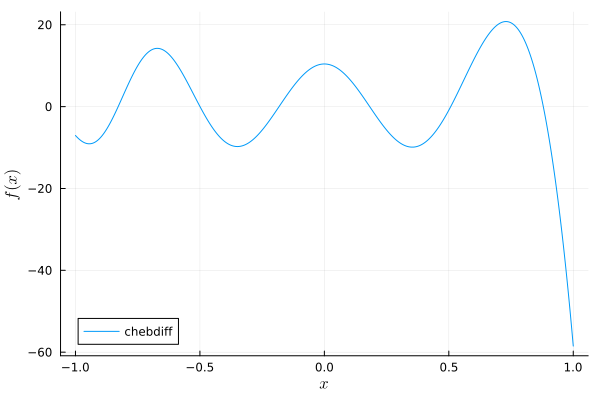

In [12]:
plot_cheb(chebdiff(a),label="chebdiff")

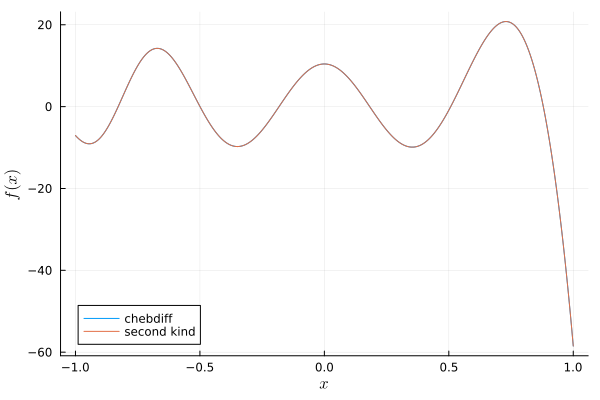

In [13]:
x = range(-1,stop=1,length=5000)
fx = clenshaw_secondkind(b,x)
plot!(x,fx,label="second kind")

見た目はほぼ一致している。さらに、各点（5000点）での関数値を比較して差をとるとほぼ同じであることがわかる。

In [14]:
norm(eval_cheb(chebdiff(a),x)-fx,Inf)

6.394884621840902e-14

本資料は以下のような文献・Web ページ等を参考にこの文章は書いています。

### 参考文献

1.  J.C. Mason and D.C. Handscomb, Chebyshev Polynomials (1st ed.), Chapman and Hall/CRC, 2002.<br>
(2.4.5章に微分操作のアルゴリズムの説明がある。この本はチェビシェフ多項式をもの凄く詳しく説明している教科書で辞書的に調べる使い方で無敵を誇る)

<div align="right">近藤慎佑, <a href="http://www.risk.tsukuba.ac.jp/~takitoshi/">高安亮紀</a>, 2023年2月22日</div>